In [1]:
!pip install deepxde
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 15.0 MB/s eta 0:00:00


In [2]:
%env DDE_BACKEND=tensorflow
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

def func(x):
    return x * np.sin(5 * x)

def get_weights(denses):
    weights = np.concatenate([layer.get_weights()[0].flatten() for layer in denses])
    biases = np.concatenate([layer.get_weights()[1] for layer in denses])
    return weights

def train(model, iterations, display_every, loss, constant):
    prev_weight = None
    for i in range(iterations):
        model.train_state.set_data_train(
            *model.data.train_next_batch(model.batch_size)
        )
        model.train_step(
            model.train_state.X_train,
            model.train_state.y_train,
            model.train_state.train_aux_vars,
        )

        X_test, y_test = model.data.test()
        y_pred = model.predict(X_test)
        l2r = np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)
        loss.append(l2r)

        w = get_weights(model.net.denses)
        if model.train_state.epoch != 0:
            num_const = 0
            for i in range(len(w)):
                if w[i] == prev_weight[i]:
                    num_const += 1
            constant.append(100*num_const/len(w))
        prev_weight = w

        model.train_state.epoch += 1
        model.train_state.step += 1
        if model.train_state.step % display_every == 0 or i + 1 == iterations:
            print(str(model.train_state.step) + " " + str(loss[-1]))

def test(seed, plot=True):
    dde.config.set_default_float("float32")
    dde.config.set_random_seed(seed)
    print("Training Float32:")
    geom = dde.geometry.Interval(-1, 1)
    num_train = 16
    num_test = 100
    data = dde.data.Function(geom, func, num_train, num_test)

    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    loss_32 = []
    constant_32 = [0]
    train(model, 10000, 1000, loss_32, constant_32) # 10000
    print([constant_32[1]] + [constant_32[10]] + [constant_32[100]] + [constant_32[1000]] + [constant_32[9999]] )

    dde.config.set_default_float("float16")
    dde.config.set_random_seed(seed)
    print("Training Float16:")
    geom = dde.geometry.Interval(-1, 1)
    num_train = 16
    num_test = 100
    data = dde.data.Function(geom, func, num_train, num_test)

    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    loss_16 = []
    constant_16 = [0]
    train(model, 10000, 1000, loss_16, constant_16) # 10000
    # print([constant_16[1]] + [constant_16[10]] + [constant_16[100]] + [constant_16[1000]] + [constant_16[9999]] )

    if plot:
        x = [i for i in range(len(loss_32))]
        plt.figure(figsize=(4.8,3.6))
        plt.ylabel('Percentage of constant weights')
        plt.xlabel('No. of iterations')
        plt.plot(x, constant_32, label = "Float32", color = 'red')
        plt.plot(x, constant_16, label = "Float16", color = 'orange')
        leg1 = plt.legend(loc = 'right', frameon=False)
        plt.savefig("constant-weights-" + str(seed) + ".pdf", bbox_inches='tight')
        plt.show()
    return (constant_32, constant_16)

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [3]:
trials = 10
const_32 = np.zeros((trials, 10000))
const_16 = np.zeros((trials, 10000))
for i in range(trials):
    const_32[i], const_16[i] = test(i, False)

Set the default float type to float32
Training Float32:
Compiling model...
'compile' took 0.004741 s

1000 0.42378733
2000 0.27962402
3000 0.047656186
4000 0.039519563
5000 0.033346605
6000 0.026610265
7000 0.020304015
8000 0.017162016
9000 0.014630942
10000 0.012125052
[0.0, 0.0, 0.0, 0.0, 0.0]
Set the default float type to float16
Training Float16:
Compiling model...
'compile' took 0.006403 s

1000 0.3599
2000 0.168
3000 0.07916
4000 0.0681
5000 0.0645
6000 0.0626
7000 0.06174
8000 0.0618
9000 0.06165
10000 0.06192
Set the default float type to float32
Training Float32:
Compiling model...
'compile' took 0.003819 s

1000 0.42936787
2000 0.0504882
3000 0.036177408
4000 0.02719522
5000 0.024877908
6000 0.023440845
7000 0.021668365
8000 0.02024778
9000 0.018011581
10000 0.016555652
[0.0, 0.0, 0.0, 0.0, 0.8333333333333334]
Set the default float type to float16
Training Float16:
Compiling model...
'compile' took 0.003558 s

1000 0.4578
2000 0.4302
3000 0.4004
4000 0.3342
5000 0.0918
6000 0

(10000,)
(10000,)


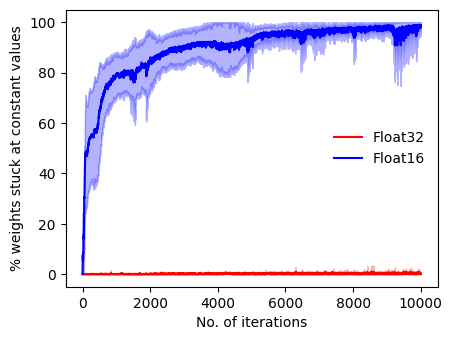

In [4]:
mean_32 = np.mean(const_32, axis = 0)
mean_16 = np.mean(const_16, axis = 0)
stdev_32 = np.std(const_32, axis = 0)
stdev_16 = np.std(const_16, axis = 0)

x = [i for i in range(len(mean_32))]
plt.figure(figsize=(4.8,3.6))
plt.xlabel('No. of iterations')
plt.ylabel('% weights stuck at constant values')
plt.plot(x, mean_32, label = "Float32", color = 'red')
plt.plot(x, mean_16, label = "Float16", color = 'blue')
print((mean_32 - stdev_32).shape)
print(np.full(10000, 0).shape)
plt.fill_between(x, np.maximum(mean_32 - stdev_32, np.full(10000, 0)), np.minimum(mean_32 + stdev_32, np.full(10000, 100)), color = 'red', alpha = 0.3)
plt.fill_between(x, np.maximum(mean_16 - stdev_16, np.full(10000, 0)), np.minimum(mean_16 + stdev_16, np.full(10000, 100)), color = 'blue', alpha = 0.3)
leg1 = plt.legend(loc = 'right', frameon=False)
plt.savefig("constant-weights.pdf", bbox_inches='tight')
plt.show()

In [ ]:
np.save("float32-constant-weights", const_32)
np.save("float16-constant-weights", const_16)